# Poisson disc sampling

Quality meshes are important for producing reliable solution in surface process modelling. For any given node in an unstructured mesh, its neighbours should be spaced more or less at an equal radius. For this we turn to Poisson disc sampling using an efficient $O(N)$ [algorithm](http://www.cs.ubc.ca/~rbridson/docs/bridson-siggraph07-poissondisk.pdf).

The premise of this algorithm is to ensure that points are tightly packed together, but no closer than a specified minimum distance. This distance can be uniform across the entire domain, or alternatively a 2D numpy array of radius lengths can be used to bunch and relax the spacing of nodes.

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import imread
from quagmire import tools as meshtools
%matplotlib inline

## Uniform spacing

### Landscape

In this example we create higher resolution where the slope is steeper.

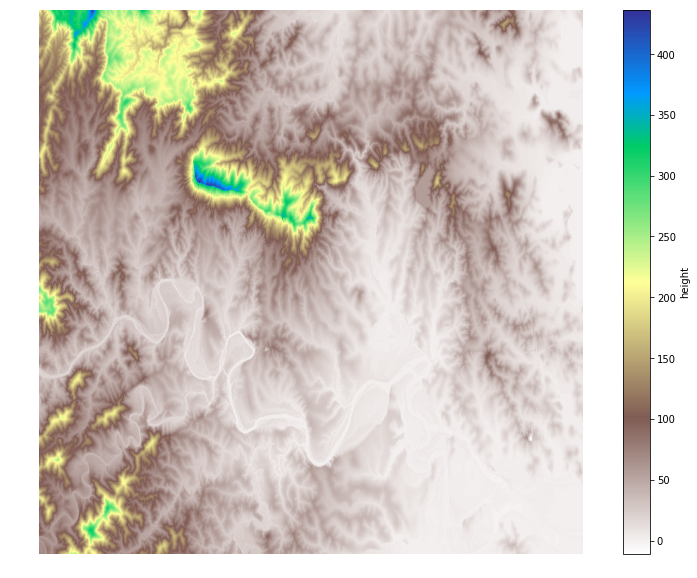

In [3]:
dem = imread('data/port_macquarie.tif', mode='F')

rows, columns = dem.shape
aspect_ratio = float(columns) / float(rows)

spacing = 5.0

minX, maxX = 0.0, spacing*dem.shape[1]
minY, maxY = 0.0, spacing*dem.shape[0]


fig = plt.figure(1, figsize=(10*aspect_ratio,10))
ax = fig.add_subplot(111)
ax.axis('off')
im = ax.imshow(dem, cmap='terrain_r', origin='lower', aspect=aspect_ratio)
fig.colorbar(im, ax=ax, label='height')

In [4]:
gradX, gradY = np.gradient(dem, 5., 5.) # 5m resolution in each direction
slope = np.hypot(gradX, gradY)

print("min/max slope {}".format((slope.min(), slope.max())))

min/max slope (0.0, 5.0558634)


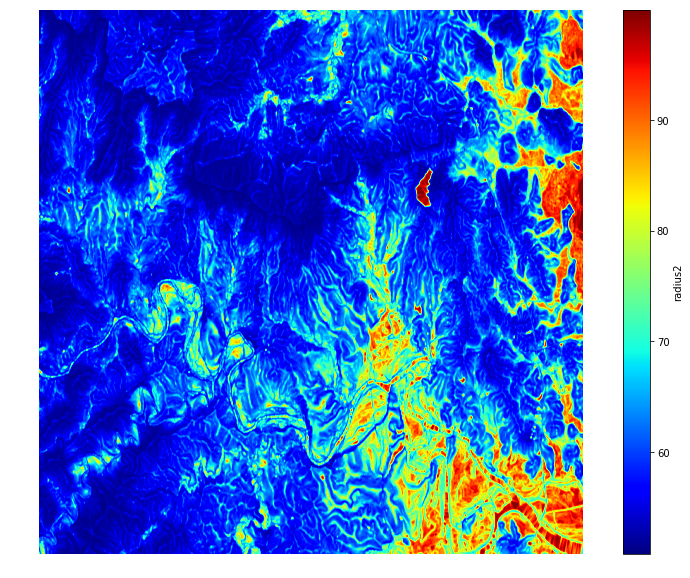

In [5]:
height, width = slope.shape

radius_min = 50.0
radius_max = 100.0

radius = 1.0/(slope + 0.02)
radius = (radius - radius.min()) / (radius.max() - radius.min()) 
radius = radius * (radius_max-radius_min) + radius_min

# apply gaussian filter for better results
from scipy.ndimage import gaussian_filter
radius2 = gaussian_filter(radius, 5.)

# radius -= slope.min()
# radius /= slope.max()/100
# radius += 1e-8

fig = plt.figure(1, figsize=(10*aspect_ratio, 10))
ax = fig.add_subplot(111)
ax.axis('off')
im = ax.imshow((radius2), cmap='jet', origin='lower', aspect=aspect_ratio)
fig.colorbar(im, ax=ax, label='radius2')

plt.show()

In [6]:
x, y, bmask = meshtools.poisson_square_mesh(minX, maxX, minY, maxY, spacing*2.0, boundary_samples=500, r_grid=radius2*2.0)
print("{} samples".format(x.size))

20555 samples


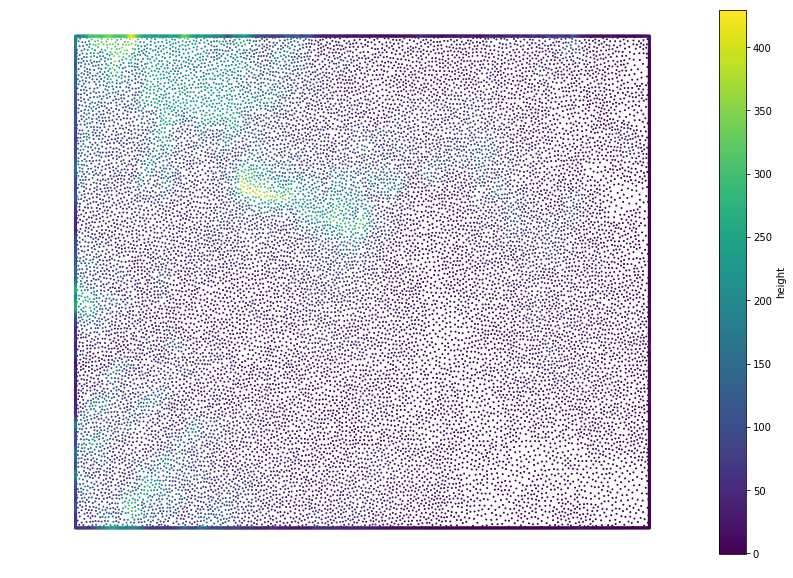

In [7]:
from scipy import ndimage

coords = np.stack((y, x)).T / spacing
meshheights = ndimage.map_coordinates(dem, coords.T, order=3, mode='nearest')


fig = plt.figure(1, figsize=(10*aspect_ratio, 10))
ax = fig.add_subplot(111)
ax.axis('off')
sc = ax.scatter(x[bmask], y[bmask], s=1, c=meshheights[bmask])
sc = ax.scatter(x[~bmask], y[~bmask], s=5, c=meshheights[~bmask])

fig.colorbar(sc, ax=ax, label='height')
plt.show()

## TriMesh

Now the points can be triangulated to become a quality unstructured mesh.

Triangulation reorders x,y points - be careful!

In [8]:
from quagmire import TopoMesh # all routines we need are within this class
from quagmire import SurfaceProcessMesh

dm = meshtools.create_DMPlex_from_points(x, y, bmask, refinement_levels=1)
mesh = SurfaceProcessMesh(dm)

# Triangulation reorders points
coords = np.stack((mesh.tri.points[:,1], mesh.tri.points[:,0])).T / spacing
meshheights = ndimage.map_coordinates(dem, coords.T, order=3, mode='nearest')
mesh.downhill_neighbours = 2

mesh.update_height(meshheights)
raw_heights = mesh.height.copy()

0 - Delaunay triangulation 0.145113s
0 - Calculate node weights and area 0.003481s
0 - Find boundaries 0.001006s
0 - cKDTree 0.01454s
0 - Construct neighbour cloud array 0.396214s
0 - Construct rbf weights 0.093403s
0 - Compute slopes 0.301386s
0 - Build downhill matrices 0.294415s


Landscape analysis statistics

In [9]:
its, flowpaths1 = mesh.cumulative_flow_verbose(mesh.area, verbose=True)
flowpaths1 = mesh.rbf_smoother(flowpaths1)

0: Max Delta - 68529.1691151 
10: Max Delta - 53642.9810857 
20: Max Delta - 36839.8281547 
30: Max Delta - 34706.6070342 
40: Max Delta - 33374.7996968 
50: Max Delta - 8394.8785787 
60: Max Delta - 3769.63054526 
70: Max Delta - 4489.3953404 
80: Max Delta - 1976.73422411 
90: Max Delta - 0.301270875972 


In [10]:
gradient_max = mesh.slope.max()
gradient_mean = mesh.slope.mean()
flat_spots = np.where(mesh.slope < gradient_mean*0.01)[0]
low_points = mesh.identify_low_points()

nodes = np.arange(0, mesh.npoints)
lows =  np.where(mesh.down_neighbour[1] == nodes)[0]

# print statistics
print("mean gradient {}\nnumber of flat spots {}\nnumber of low points {}".format(gradient_mean,
                                                                                  flat_spots.size,
                                                                                  low_points.shape[0]))

mean gradient 0.131130129099
number of flat spots 647
number of low points 618


In [11]:
## low point catchments 

import petsc4py
from petsc4py import PETSc

for i in range(0,2):
    low_points = mesh.identify_low_points()
    print "# lows:", low_points.shape
    glow_points = mesh.lgmap_row.apply(low_points.astype(PETSc.IntType))
    ctmt = mesh.uphill_propagation(low_points,  glow_points, its=250, fill=-1).astype(np.int)
    
    edges = np.where(ctmt[mesh.down_neighbour[2]] != ctmt )[0]  ## local_numbering

    my_catchments = np.unique(ctmt)
    
    spills = np.empty((edges.shape[0]), 
                     dtype=np.dtype([('c', int), ('h', float), ('x', float), ('y', float)]))

    ii = 0
    for l, this_low in enumerate(my_catchments):    
        this_low_spills = edges[np.where(ctmt[edges] == this_low)]  ## local numbering
        
        for spill in this_low_spills:
            spills['c'][ii] = this_low  
            spills['h'][ii] = mesh.height[spill]
            spills['x'][ii] = mesh.coords[spill,0]
            spills['y'][ii] = mesh.coords[spill,1]
            ii += 1

    spills.sort(axis=0)  # Sorts by catchment then height ...   
    s, indices = np.unique(spills['c'], return_index=True)  
    spill_points = spills[indices]

    
    height2 = np.zeros_like(mesh.height)
    
    for i, spill in enumerate(spill_points):
        this_catchment = int(spill[0])
        if this_catchment < 0:
            continue
            
        catchment_nodes = np.where(ctmt == this_catchment)
        separation_x = (mesh.coords[catchment_nodes,0] - spill['x'])
        separation_y = (mesh.coords[catchment_nodes,1] - spill['y'])
        distance = np.hypot(separation_x, separation_y)
    
        height2[catchment_nodes] = spill[1] + 0.000001 * distance
        
    height2 = np.maximum(mesh.height, height2)

    mesh._update_height_partial(height2)
    low_points2 = mesh.identify_low_points()
    print "# lows:", low_points2.shape

new_heights=mesh.low_points_local_fill_old(its=2, smoothing_steps=2)
mesh._update_height_partial(new_heights)
low_points2 = mesh.identify_low_points()
print low_points2.shape

# lows: (618,)
75  iterations, time =  0.544626
 - Partial rebuild of downhill matrices 0.261479s
# lows: (193,)
# lows: (193,)
86  iterations, time =  0.709961
 - Partial rebuild of downhill matrices 0.237939s
# lows: (78,)


AttributeError: 'SurfaceProcessMeshClass' object has no attribute 'low_points_local_fill_old'

In [ ]:
fig = plt.figure(1, figsize=(20,20))
ax = fig.add_subplot(111)
ax.axis('off')
#
m1=ax.scatter(mesh.tri.x, mesh.tri.y, s=20.0, marker="s", c=mesh.height-raw_heights, cmap="jet", alpha=0.33)
# ax.scatter(mesh.tri.x[low_points], mesh.tri.y[low_points], s=50.0, marker="o", c=ctmt[low_points], cmap="jet")
# ax.scatter(mesh.tri.x[edges], mesh.tri.y[edges], s=10.0, marker="x", c=ctmt[edges], cmap="jet")


#ax.scatter(mesh.tri.x[spills], mesh.tri.y[spills], marker="x", s=50.0, c=raw_heights[spills], cmap="jet_r")
#ax.scatter(mesh.tri.x[bad_low_nodes], mesh.tri.y[bad_low_nodes], marker="+", s=50.0, color="#448844")


fig.colorbar(m1, ax=ax)

plt.show()

In [ ]:
for i in range(0,5):
    a, new_heights = mesh.low_points_swamp_fill()
    mesh._update_height_partial(new_heights)
    # mesh.update_height(new_heights)
    low_points2 = mesh.identify_low_points()
    print low_points2.shape


In [12]:
new_heights

NameError: name 'new_heights' is not defined

In [ ]:
mesh.downhill_neighbours = 2
mesh.update_height(mesh.height)

its, flowpaths2 = mesh.cumulative_flow_verbose(mesh.area, maximum_its=2500, verbose=True)
flowpaths2 = mesh.rbf_smoother(flowpaths2)

In [ ]:
fig = plt.figure(1, figsize=(20,20))
ax = fig.add_subplot(111)
ax.axis('off')
#im1 = ax.tripcolor(mesh.tri.x, mesh.tri.y, mesh.tri.simplices, ctmt, linewidth=0.1, cmap='jet')
#fig.colorbar(im1, ax=ax, label='slope')
# m1 = ax.scatter(mesh.tri.x, mesh.tri.y, c=new_heights-raw_heights, marker="o", cmap="Greys")
ax.scatter(mesh.tri.x, mesh.tri.y, s=20.0, marker="s", c=ctmt, cmap="jet", alpha=0.33)
ax.scatter(mesh.tri.x[low_points], mesh.tri.y[low_points], s=50.0, marker="o", c=ctmt[low_points], cmap="jet")
ax.scatter(mesh.tri.x[edges], mesh.tri.y[edges], s=10.0, marker="x", c=ctmt[edges], cmap="jet")


#ax.scatter(mesh.tri.x[spills], mesh.tri.y[spills], marker="x", s=50.0, c=raw_heights[spills], cmap="jet_r")
#ax.scatter(mesh.tri.x[bad_low_nodes], mesh.tri.y[bad_low_nodes], marker="+", s=50.0, color="#448844")


fig.colorbar(m1, ax=ax)

plt.show()

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,10))
    
im1 = ax1.tripcolor(mesh.tri.x, mesh.tri.y, mesh.tri.simplices, raw_heights , cmap='terrain')
ax1.scatter(mesh.tri.x[low_points], mesh.tri.y[low_points], color="Red",  s=1.0)
im2 = ax2.tripcolor(mesh.tri.x, mesh.tri.y, mesh.tri.simplices, np.log(np.sqrt(flowpaths2)) , cmap='Blues')

# ax2.scatter(mesh.tri.x[spills], mesh.tri.y[spills], color="Green", marker="*", s=20.0)

ax2.scatter(mesh.tri.x[low_points2], mesh.tri.y[low_points2], color="Red", s=5.0)

# lakes = np.where((new_heights - raw_heights) > 5.0 )[0]
# ax2.scatter(mesh.tri.x[lakes], mesh.tri.y[lakes], c=new_heights[lakes]-raw_heights[lakes], s=3.0, marker="o", cmap="Greens", vmax=None, alpha=0.5)



# fig.colorbar(im1, ax=ax1)
plt.show()

In [ ]:
filename = 'portmacca1.h5'

mesh.save_mesh_to_hdf5(filename)
mesh.save_field_to_hdf5(filename, height0=raw_heights, height=mesh.height, slope=mesh.slope, flow=np.sqrt(flowpaths2), lakes=(mesh.height - raw_heights))

# to view in Paraview
meshtools.generate_xdmf(filename)

In [ ]:
import petsc4py



In [ ]:
print mesh.gvec.getOwnershipRange()
LGmap = mesh.dm.getLGMap()
print mesh.lgmap_col.apply(100)

In [ ]:
import mpi4py
from mpi4py import MPI

comm = MPI.COMM_WORLD
size = comm.Get_size()
rank = comm.Get_rank()


In [ ]:
E1 = np.where(ctmt[mesh.down_neighbour[2]] != ctmt )[0]
E2 = np.where(~bmask)[0]

print E1.shape
print E2.shape

E3 = np.unique(np.hstack((E1,E2)))

In [ ]:
low_points = mesh.identify_low_points()
print "# lows:", low_points.shape
glow_points = mesh.lgmap_row.apply(low_points.astype(PETSc.IntType))
ctmt = mesh.uphill_propagation(low_points,  glow_points, its=250, fill=-1).astype(np.int)

edges = np.where(ctmt[mesh.down_neighbour[2]] != ctmt )[0]  ## local_numbering

